# Wildfires localization (Alaska 2004 - 2005)
## A proof of concept on a small area ~100 km<sup>2</sup> (fix size)
---------------------------------

We need first of all to add the root directory of the repository to the Python paths. The mlfire package is located there.

In [1]:
import sys
import os

TOOLS_DIR = os.path.abspath('..')
sys.path.append(TOOLS_DIR)

Here, we import a functionality for lazy loading packages. It is a mechanism for lazy, or "*on demand*", importing packages or particular modules. This practice helps to delay loading the sections of this notebook and initializing
objects until they are really needed. The packages used in this example will be loaded using this approach then.

In [2]:
from mlfire.utils.functool import lazy_import

All source files (GeoTIFF images) used in this example were downloaded from the Google Earth Engine using our in-house software written in Python and based on Google Earth Engine API and Google Cloud. Recall, the Google Earth Engine is a platform which combines a multi-petabyte catalog of satellite imagery and geospatial datasets with planetary-scale analysis capabilities. [[https://earthengine.google.com](https://earthengine.google.com)]

In [3]:
ee_collections = lazy_import('mlfire.earthengine.collections')

And here lazy loading modules which we will use for processing and displaying sources.

In [4]:
data_loader = lazy_import('mlfire.data.loader')
data_ts = lazy_import('mlfire.data.ts')
data_fuze = lazy_import('mlfire.data.fuze')
data_view = lazy_import('mlfire.data.view')

features_pca = lazy_import('mlfire.features.pca')

A model for localization of wildfires introduced in this example is trained using the gradient boosting approach implemented in XGBoost.

In [5]:
xgboost = lazy_import('xgboost')
xgboost_inference = lazy_import('mlfire.models.xgboost.inference')
xgboost_train = lazy_import('mlfire.models.xgboost.train')

The last packages that we need to import will be used as helpers for displaying sources and results as well.

In [6]:
itertools = lazy_import('itertools')

plt_pylab = lazy_import('matplotlib.pylab')
plt_utils = lazy_import('mlfire.utils.plots')

In [7]:
io_utils = lazy_import('mlfire.utils.io')

## Names of sources (satellite images and labels)

A prefix of images (satellite images and labels) and a location where images are placed.

In [8]:
DATA_DIR = os.path.join(TOOLS_DIR, 'data/tifs')

PREFIX_REFLECTANCE_IMG = 'ak_reflec_january_december_{}_100km'
PREFIX_TEMPSURFACE_IMG = 'ak_lst_january_december_{}_100km'

PREFIX_LABEL_IMG = 'ak_january_december_{}_100km'

We use the MTBS labelling for wildfires in this example. See the Google Earth Engine catalog on https://developers.google.com/earth-engine/datasets/catalog/USFS_GTAC_MTBS_annual_burn_severity_mosaics_v1 for futher details.

In [9]:
LABEL_COLLECTION = data_loader.FireMapSelectOpt.MTBS
STR_LABEL_COLLECTION = LABEL_COLLECTION.name.lower()

Here, we set file names of satellite images and corresponding labels using prefixes and a location and store the names to lists.

In [10]:
lst_satimgs_reflectance = []
lst_satimgs_tempsurface = []

lst_labels = []

for year in range(2004, 2006):

    PREFIX_LABEL_IMG_YEAR = PREFIX_LABEL_IMG.format(year)
    PREFIX_REFLECTANCE_IMG_YEAR = PREFIX_REFLECTANCE_IMG.format(year)
    PREFIX_TEMPSURFACE_IMG_YEAR = PREFIX_TEMPSURFACE_IMG.format(year)

    fn_satimg_reflec = '{}_epsg3338_area_0.tif'.format(PREFIX_REFLECTANCE_IMG_YEAR)
    fn_satimg_reflec = os.path.join(DATA_DIR, fn_satimg_reflec)
    lst_satimgs_reflectance.append(fn_satimg_reflec)
    
    fn_satimg_temp = '{}_epsg3338_area_0.tif'.format(PREFIX_TEMPSURFACE_IMG_YEAR)
    fn_satimg_temp = os.path.join(DATA_DIR, fn_satimg_temp)
    lst_satimgs_tempsurface.append(fn_satimg_temp)

    fn_labels = '{}_epsg3338_area_0_{}_labels.tif'.format(PREFIX_LABEL_IMG_YEAR, STR_LABEL_COLLECTION)
    fn_labels = os.path.join(DATA_DIR, fn_labels)
    lst_labels.append(fn_labels)

A list of the satellite images (reflectance).

In [11]:
lst_satimgs_reflectance

['/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2004_100km_epsg3338_area_0.tif',
 '/Users/marek/Playground/wildfires/data/tifs/ak_reflec_january_december_2005_100km_epsg3338_area_0.tif']

In [12]:
lst_satimgs_tempsurface

['/Users/marek/Playground/wildfires/data/tifs/ak_lst_january_december_2004_100km_epsg3338_area_0.tif',
 '/Users/marek/Playground/wildfires/data/tifs/ak_lst_january_december_2005_100km_epsg3338_area_0.tif']

And, a list of the firemaps.

In [13]:
lst_labels

['/Users/marek/Playground/wildfires/data/tifs/ak_january_december_2004_100km_epsg3338_area_0_mtbs_labels.tif',
 '/Users/marek/Playground/wildfires/data/tifs/ak_january_december_2005_100km_epsg3338_area_0_mtbs_labels.tif']

## Data adapter settings

In [14]:
SatDataPreprocessOpt = data_ts.SatDataPreprocessOpt
FactorOP = features_pca.FactorOP

TRANSFORM_OPS = (
    SatDataPreprocessOpt.STANDARTIZE_ZSCORE, 
    SatDataPreprocessOpt.SAVITZKY_GOLAY,
    SatDataPreprocessOpt.PCA_PER_BAND, 
    SatDataPreprocessOpt.NOT_PROCESS_UNCHARTED_PIXELS
)

PCA_OPS = [FactorOP.CUMULATIVE_EXPLAINED_VARIANCE]
PCA_RETAINED_VARIANCE = 0.8 # 30% information could be noisy

We horizontally split the images and corresponding labels. The top 66.6 percent is used as a training data set and a remaining part of the images as a test data set.

In [15]:
SatDataSplitOpt = data_ts.SatDataSplitOpt
DS_SPLIT_OPT = SatDataSplitOpt.IMG_HORIZONTAL_SPLIT

TEST_RATIO = 1. / 3.

Vegetation index

In [16]:
VegetationSelect = data_fuze.VegetationIndexSelectOpt
ADD_VI = [VegetationSelect.NDVI, VegetationSelect.EVI, VegetationSelect.EVI2]

And, we set up a data adapter then.

In [17]:
adapter_ts = data_ts.SatDataAdapterTS(
    lst_firemaps=lst_labels,
    lst_satdata_reflectance=lst_satimgs_reflectance,
    lst_satdata_temperature=lst_satimgs_tempsurface,
    # fire map collection
    opt_select_firemap=LABEL_COLLECTION,
    mtbs_min_severity=ee_collections.MTBSSeverity.LOW,
    # filtering spectral data using Savitzky-Golay filter
    savgol_polyorder=4,
    savgol_winlen=10,
    # vegetation index
    lst_vegetation_add=ADD_VI,
    # transformation options
    opt_preprocess_satdata=TRANSFORM_OPS,
    opt_pca_factor=PCA_OPS,
    pca_retained_variance=PCA_RETAINED_VARIANCE,
    # data set split options
    opt_split_satdata=DS_SPLIT_OPT,
    test_ratio=TEST_RATIO,
)

## Dates of bands associated with satallite images and labels

In [18]:
if adapter_ts.lst_satdata_reflectance is not None:  adapter_ts.timestamps_reflectance

Start event: 'processing timestamps (reflectance)'.
Finnish event: 'processing timestamps (reflectance)'. It takes 0.05s.


In [19]:
if adapter_ts.lst_satdata_temperature is not None: adapter_ts.timestamps_temperature

Start event: 'processing timestamps (temperature)'.
Finnish event: 'processing timestamps (temperature)'. It takes 0.06s.


In [20]:
adapter_ts.timestamps_firemaps

Start event: 'processing timestamps (mtbs fire maps)'.
Finnish event: 'processing timestamps (mtbs fire maps)'. It takes 0.00s.


,Timestamps,Image ID
0,2004-01-01,0
1,2005-01-01,1


### Satellite image

In [21]:
SatImgViewOpt = data_view.SatImgViewOpt
lst_view_opt = [SatImgViewOpt.NATURAL_COLOR, SatImgViewOpt.SHORTWAVE_INFRARED1, 
                SatImgViewOpt.CIR, SatImgViewOpt.NDVI,
                SatImgViewOpt.EVI, SatImgViewOpt.EVI2]

In [22]:
IMG_ID = 70
adapter_ts.ndvi_view_threshold = .5

Start event: 'processing layout of layers (reflectance)'.
Finnish event: 'processing layout of layers (reflectance)'. It takes 0.01s.
Start event: 'processing layout of layers (temperature)'.
Finnish event: 'processing layout of layers (temperature)'. It takes 0.00s.


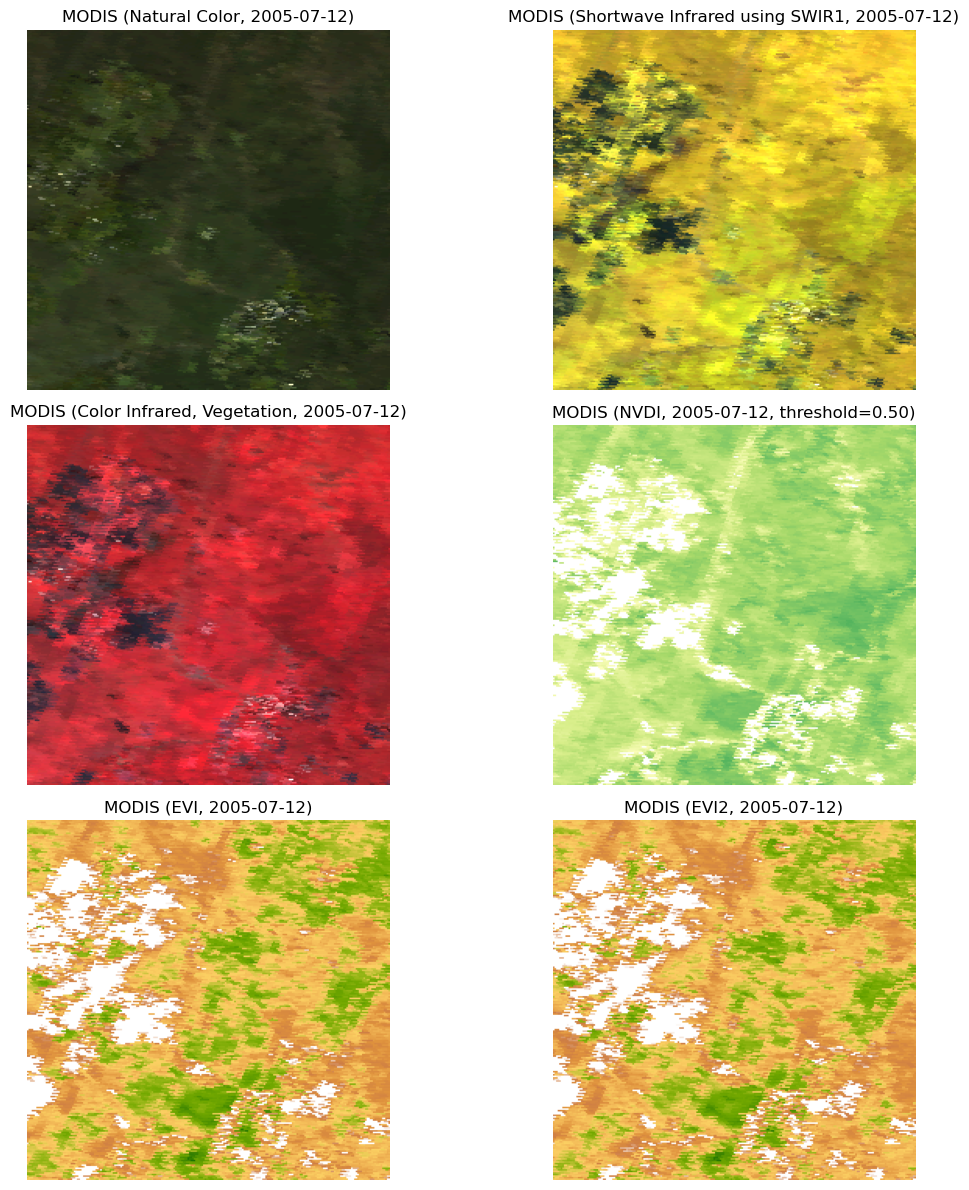

In [23]:
# TODO fix for case when reflectance is not specified
fig, axes = plt_pylab.subplots(3, 2, figsize=(15, 12))

for i, j in itertools.product(*[range(3)], *[range(2)]):
        
    adapter_ts.satimg_view_opt = lst_view_opt[2 * i + j]
    adapter_ts.showSatImage(IMG_ID, ax=axes[i][j], show=False)

plt_pylab.show()

### Firemaps (MTBS)

In [24]:
WITH_UNCHARTED_AREAS=True

Start event: 'processing layout of layers (mtbs fire maps)'.
Finnish event: 'processing layout of layers (mtbs fire maps)'. It takes 0.00s.


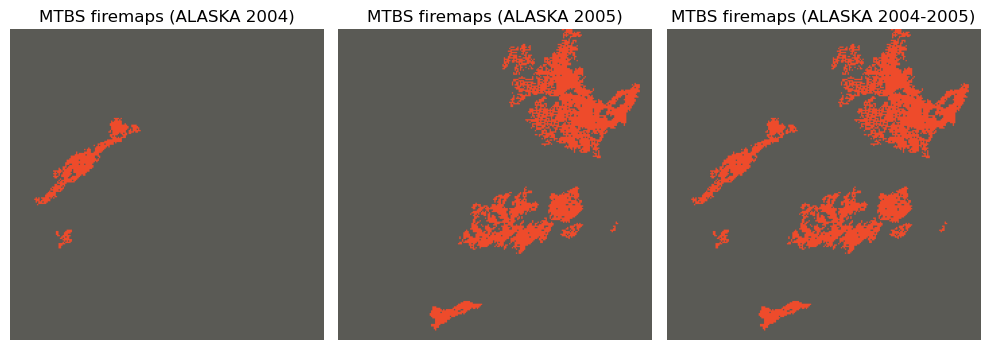

In [25]:
_, axes = plt_pylab.subplots(1, 3, figsize=(10, 12))

adapter_ts.showFireLabels(
    id_bands=0, figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[0]
)
adapter_ts.showFireLabels(
    id_bands=1, figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[1]
)
adapter_ts.showFireLabels(
    id_bands=range(0, 2), figsize=(3.5, 3.5), show_uncharted_areas=WITH_UNCHARTED_AREAS, show=False, ax=axes[2]
)

In [26]:
BRIGHTNESS_FACTORS=(7, 7)

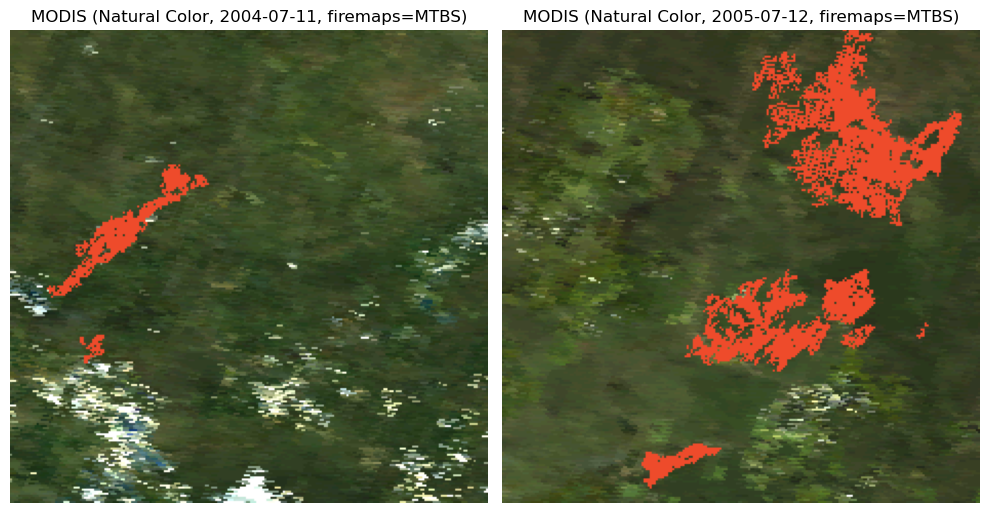

In [27]:
# TODO fix for case when reflectance is not specified
_, axes = plt_pylab.subplots(1, 2, figsize=(10, 10))

adapter_ts.satimg_view_opt = SatImgViewOpt.NATURAL_COLOR
adapter_ts.showSatImageWithFireLabels(
    id_img=24, brightness_factors=BRIGHTNESS_FACTORS, figsize=(3.5, 3.5), show=False, ax=axes[0]
)
adapter_ts.showSatImageWithFireLabels(
    id_img=70, brightness_factors=BRIGHTNESS_FACTORS,figsize=(3.5, 3.5), show=False, ax=axes[1]
)

## Creating data sets

In [28]:
id_start_date = 0
start_timestamp = adapter_ts.timestamps_satdata.iloc[id_start_date]['Timestamps']
print('Data set start date {}'.format(start_timestamp))

Data set start date 2004-01-01


In [29]:
id_end_date = -1
end_timestamp = adapter_ts.timestamps_satdata.iloc[id_end_date]['Timestamps']
print('Data set end date {}'.format(end_timestamp))

Data set end date 2005-12-27


In [30]:
adapter_ts.selected_timestamps = (start_timestamp, end_timestamp)
adapter_ts.createDatasets()

Start event: 'processing timestamps (reflectance)'.
Finnish event: 'processing timestamps (reflectance)'. It takes 0.08s.
Start event: 'processing layout of layers (reflectance)'.
Finnish event: 'processing layout of layers (reflectance)'. It takes 0.01s.
Start event: 'processing timestamps (temperature)'.
Finnish event: 'processing timestamps (temperature)'. It takes 0.06s.
Start event: 'processing layout of layers (temperature)'.
Finnish event: 'processing layout of layers (temperature)'. It takes 0.00s.
Start event: 'loading satellite data (reflectance)'.
Start event: 'loading data from img #0'.
Finnish event: 'loading data from img #0'. It takes 0.36s.
Start event: 'loading data from img #1'.
Finnish event: 'loading data from img #1'. It takes 0.47s.
Finnish event: 'loading satellite data (reflectance)'. It takes 1.02s.
Start event: 'loading satellite data (temperature)'.
Start event: 'loading data from img #0'.
Finnish event: 'loading data from img #0'. It takes 0.05s.
Start event

In [31]:
ds_train = adapter_ts.getTrainingDataset()
ds_test = adapter_ts.getTestDataset()

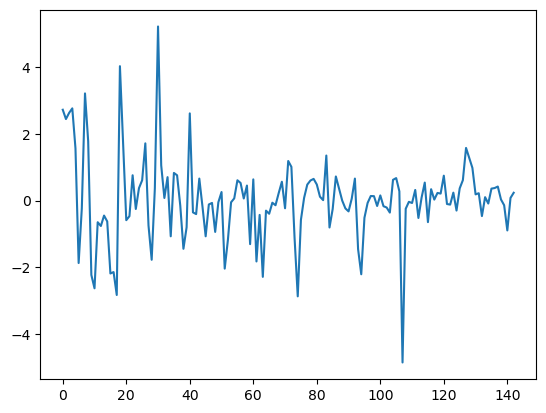

In [32]:
from matplotlib import pyplot
import numpy as np

np_satdata = ds_train[0]; px = np_satdata[0, 0, :]
idx = np.arange(len(px))

pyplot.plot(idx, px)

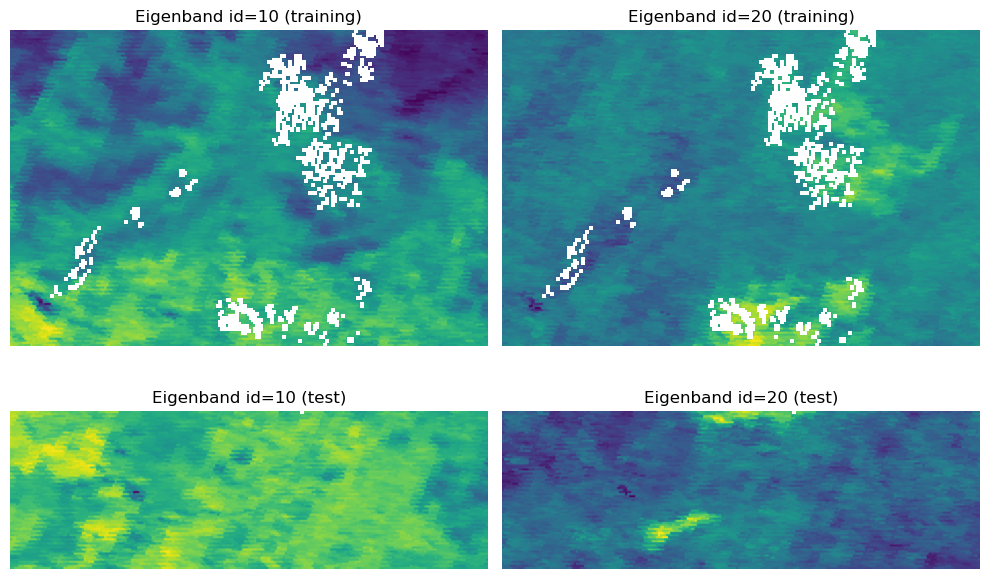

In [33]:
_, axes = plt_pylab.subplots(2, 2, figsize=(10, 7))

img_train = ds_train[0]
img_test = ds_test[0]

plt_utils.imshow(img_train[:, :, 10], title='Eigenband id=10 (training)', ax=axes[0][0])
plt_utils.imshow(img_train[:, :, 20], title='Eigenband id=20 (training)', ax=axes[0][1])
plt_utils.imshow(img_test[:, :, 10], title='Eigenband id=10 (test)', ax=axes[1][0])
plt_utils.imshow(img_test[:, :, 20], title='Eigenband id=20 (test)', ax=axes[1][1])

### Training a boosted tree classification model

In [34]:
xgb = xgboost.XGBClassifier(objective='binary:logistic')
xgboost_train.trainSegmentationModel(xgb=xgb, ds=ds_train)

Start event: 'Training XGBoost model'.
Finnish event: 'Training XGBoost model'. It takes 15.86s.


### Inference on the train data set

In [35]:
SHOW_UNCHARTED_AREAS=True

Classification report:

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     29444
         1.0       0.89      0.91      0.90      5585

    accuracy                           0.97     35029
   macro avg       0.94      0.94      0.94     35029
weighted avg       0.97      0.97      0.97     35029


Classification report (imbalanced):

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.98      0.91      0.98      0.94      0.90     29444
        1.0       0.89      0.91      0.98      0.90      0.94      0.88      5585

avg / total       0.97      0.97      0.92      0.97      0.94      0.89     35029


IoU- (intersection over union): 0.96

IoU+ (intersection over union): 0.82

mIoU (mean IoU): 0.89




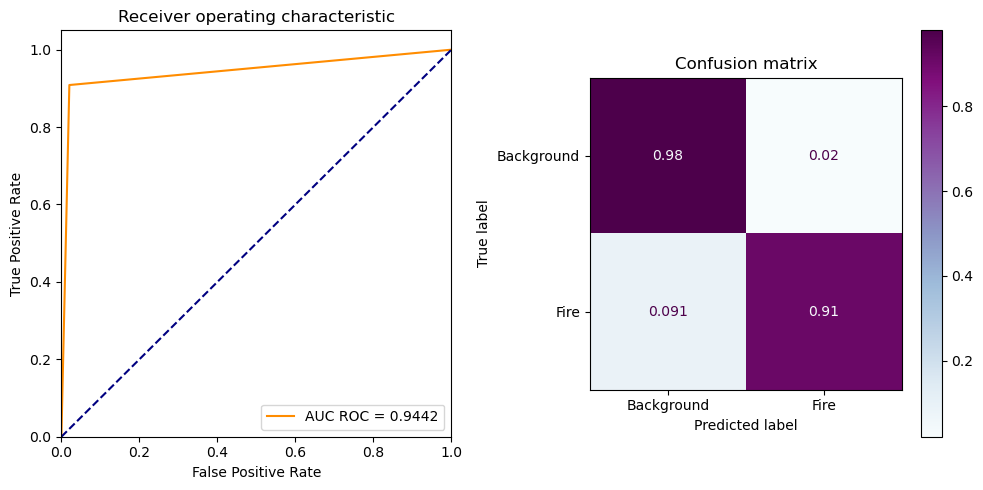

In [36]:
labels_pred = xgboost_inference.predict(
    xgb=xgb, 
    ds=ds_train,
    show_report=True,
    report_with_aucroc=True,
    report_with_cmat=True,
    report_with_scores=True
)

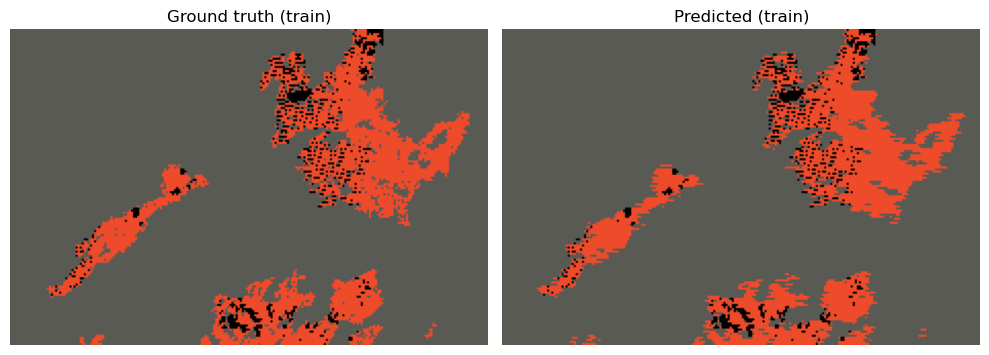

In [37]:
_, axes = plt_pylab.subplots(1, 2, figsize=(10, 9))

plt_utils.labelshow(
    ds_train[1], 
    with_uncharted_areas=SHOW_UNCHARTED_AREAS,
    title='Ground truth (train)', 
    ax=axes[0],
    show=False
)

plt_utils.labelshow(
    labels_pred,
    with_uncharted_areas=SHOW_UNCHARTED_AREAS,
    title='Predicted (train)',
    ax=axes[1],
    show=False
)

plt_pylab.show()

### Inference on the test data set

In [ ]:
labels_pred = xgboost_inference.predict(
    xgb=xgb, 
    ds=ds_test, 
    show_report=True,
    report_with_aucroc=True,
    report_with_cmat=True,
    report_with_scores=True
)

Classification report:

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     17223
         1.0       0.85      0.73      0.79       717

    accuracy                           0.98     17940
   macro avg       0.92      0.86      0.89     17940
weighted avg       0.98      0.98      0.98     17940


Classification report (imbalanced):

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.99      0.73      0.99      0.85      0.75     17223
        1.0       0.85      0.73      0.99      0.79      0.85      0.71       717

avg / total       0.98      0.98      0.74      0.98      0.85      0.75     17940


IoU- (intersection over union): 0.98

IoU+ (intersection over union): 0.65

mIoU (mean IoU): 0.82




In [ ]:
_, axes = plt_pylab.subplots(1, 2, figsize=(10, 9))

plt_utils.labelshow(
    ds_test[1], 
    with_uncharted_areas=SHOW_UNCHARTED_AREAS, 
    title='Ground truth (test)',  
    ax=axes[0],
    show=False
)

plt_utils.labelshow(
    labels_pred,
    with_uncharted_areas=SHOW_UNCHARTED_AREAS,
    title='Predicted (test)',
    ax=axes[1],
    show=False
)

plt_pylab.show()